In [122]:
from utils import bulk_retrieve_works, search_by_title
from data_members import Node, Graph
from text_extraction import extract_pdf_text_from_url

In [3]:
%load_ext autoreload
%autoreload 2

### Getting search query and extracting references

In [4]:
title_query = "Attention is all you need"

In [5]:
works = search_by_title(title_query)

1. See if it has a fulltext available
2. If it does scrape and verify
3. Final node fulltext check cleans fulltext and adds it to the node
4. The graph can filter nodes based on whether there fulltext is available or not

In [117]:
def convert_work_to_node(work, validate_fulltext: bool = False):

    node = Node()
    
    try:
        node.id = work['id'].rstrip('/').split('/')[-1]
        node.title = work['title']
        node.primary_topic = work['primary_topic']['display_name']
        node.subfield = work['primary_topic']['subfield']["display_name"]
        node.field = work['primary_topic']['field']["display_name"]
        node.domain = work['primary_topic']['domain']["display_name"]
        #subfields = [i['display_name'] for i in work['primary_topic']['subfield']]
        node.topics = [i['display_name'] for  i in  work['topics']]
        node.keywords = [i['display_name'] for i in work['keywords']]
        node.total_citations = work['cited_by_count']
        node.publication_year = work['publication_year']
        node.doi = work['doi']
        node.authors = work['authorships']
        node.cites_by_id = [url.rstrip('/').split('/')[-1] for url in work['referenced_works']]

        if work['has_fulltext']:
            oa_url = work['open_access']['oa_url']

            fulltext = extract_pdf_text_from_url(oa_url)
            if fulltext:
                node.has_fulltext = True
                node.fulltext = fulltext
            else:
                node.has_fulltext = False
        else:
            node.has_fulltext = False
            
    except Exception as e:
        print(f"Exception {e}")

    return node


In [118]:
selected_work = works[2]

primary_node = convert_work_to_node(selected_work)

referenced_works = bulk_retrieve_works(primary_node.cites_by_id, extract_from_url=False)


### Creating graph and nodes

In [69]:
import random

In [110]:
node1 = convert_work_to_node(referenced_works[7])

In [111]:
node1.has_fulltext

True

In [129]:
referenced_nodes = [convert_work_to_node(i) for i in referenced_works]

Pdf extraction error Invalid URL 'None': No scheme supplied. Perhaps you meant https://None?


In [130]:
for i in referenced_nodes:
    if i.has_fulltext:
        print(i.fulltext[:200])
        print()

Proceedings of SSST-8, Eighth Workshop on Syntax, Semantics and Structure in Statistical Translation, pages 103–111, October 25, 2014, Doha, Qatar. c⃝2014 Association for Computational Linguistics On 

HAL Id: inria-00544230 https://inria.hal.science/inria-00544230v1 Submitted on 7 Dec 2010 HAL is a multi-disciplinary open access archive for the deposit and dissemination of scientific research docum

Deep clustering: Discriminative embeddings for segmentation and separation John R. Hershey MERL Cambridge, MA hershey@merl.com Zhuo Chen Columbia University New York, NY zc2204@columbia.edu Jonathan L

SDR – HALF-BAKED OR WELL DONE? Jonathan Le Roux1, Scott Wisdom2, Hakan Erdogan3, John R. Hershey2 1Mitsubishi Electric Research Laboratories (MERL), Cambridge, MA, USA 2Google AI Perception, Cambridge

1 Multi-talker Speech Separation with Utterance-level Permutation Invariant Training of Deep Recurrent Neural Networks Morten Kolbæk, Student Member, IEEE, Dong Yu, Senior Member, IEEE, Zheng-

In [94]:
for i in referenced_nodes:
    print(i.has_fulltext)

False
True
False
False
False
True
True
True
True
True
True
True
False
True
False
True
True
False
True
False
True
False
True
True
False
False
False
True
True
False
False
False


In [99]:
referenced_nodes[5].fulltext

AttributeError: 'Node' object has no attribute 'fulltext'

In [76]:
graph = Graph(nodes = [primary_node] + referenced_nodes, primary_node=primary_node, search_query="Attention is all you need in speech seperation")

In [78]:
for i in graph.nodes:
    i.relevance = random.random()

In [80]:
graph.get_json()

{'search_query': 'Attention is all you need in speech seperation',
 'primary_node_id': 'Attention Is All You Need In Speech Separation',
 'nodes': [{'id': 'W3163652268',
   'title': 'Attention Is All You Need In Speech Separation',
   'year': 2021,
   'keywords': ['Upsampling'],
   'topic': 'Speech and Audio Processing',
   'related_topics': ['Music and Audio Processing',
    'Speech Recognition and Synthesis'],
   'field': 'Computer Science',
   'subfield': 'Signal Processing',
   'domain': 'Physical Sciences',
   'relevance': 0.5131529834314412,
   'doi': 'https://doi.org/10.1109/icassp39728.2021.9413901',
   'citations': 420},
  {'id': 'W1522301498',
   'title': 'Adam: A Method for Stochastic Optimization',
   'year': 2014,
   'keywords': [],
   'topic': 'Stochastic Gradient Optimization Techniques',
   'related_topics': ['Advanced Bandit Algorithms Research',
    'Machine Learning and ELM'],
   'field': 'Computer Science',
   'subfield': 'Artificial Intelligence',
   'domain': 'Phy

In [154]:
for i in nodes:
    i.position = get_random_position(scale_by=3)

In [141]:
nodes[0].position = (0.5, 0.5)

In [17]:
import random

In [18]:
def get_random_position(scale_by=1):
    return (random.random() * scale_by, random.random() * scale_by)

In [129]:
positions = {node.id: get_random_position() for node in graph.nodes}
#edges = [[(node.id, k) for k in node.cites_by_id if node.cites_by_id] for node in graph.nodes]
edges = [(primary_node.id, k) for k in primary_node.cites_by_id]

In [157]:
positions[graph.primary_node.id] = (1.5 ,1.5)

In [131]:
import matplotlib.pyplot as plt

### Cosine distance - getting relevance through the keywords

In [20]:
graph.get_json()

{'search_query': 'Attention is all you need in speech seperation',
 'primary_node_id': 'Attention Is All You Need In Speech Separation',
 'nodes': [{'id': 'W3163652268',
   'title': 'Attention Is All You Need In Speech Separation',
   'year': 2021,
   'keywords': ['Upsampling'],
   'topic': 'Speech and Audio Processing',
   'related_topics': ['Music and Audio Processing',
    'Speech Recognition and Synthesis'],
   'position': (1.0, 1.0),
   'doi': 'https://doi.org/10.1109/icassp39728.2021.9413901',
   'citations': 420},
  {'id': 'W1522301498',
   'title': 'Adam: A Method for Stochastic Optimization',
   'year': 2014,
   'keywords': [],
   'topic': 'Stochastic Gradient Optimization Techniques',
   'related_topics': ['Advanced Bandit Algorithms Research',
    'Machine Learning and ELM'],
   'position': (1.0, 1.0),
   'doi': None,
   'citations': 84897},
  {'id': 'W2064675550',
   'title': 'Long Short-Term Memory',
   'year': 1997,
   'keywords': [],
   'topic': 'Neural Networks and Appl

In [15]:

from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [21]:

from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity(keywords1, keywords2):
    if not keywords1 or not keywords2:
        print("⚠ One paper has no keywords. Returning similarity=0.")
        return 0.0
    emb1 = embedder.encode(keywords1)
    emb2 = embedder.encode(keywords2)
    sims = cosine_similarity(emb1, emb2)
    return sims.max(axis=1).mean()

In [32]:
relevances = []

# Send it in a random direction based on how relevant it is
for i in graph.nodes:
    if hasattr(i, 'topics'):
        keywords1 = i.topics
        keywords2 = primary_node.topics
        print(compute_similarity(keywords1, keywords2))
        relevances.append((1 - float(compute_similarity(keywords1, keywords2))))
    else:
        relevances.append(1.0)


c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.

0.99999994
0.26685244
0.2976871
0.3443735


c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.

0.30101874
0.3443735
0.3029654
0.58201057
0.79603106
0.57020444
1.0
1.0
1.0


c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.

0.79499406
0.79603106
0.99999994
0.5447545


c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.

1.0
1.0
1.0
0.99999994
0.99999994


c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.

0.99999994
0.99999994
0.99999994
1.0
1.0


c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.

1.0
0.79603106
0.78597945
0.99999994
1.0
0.3204777


c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\Parv\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\nn\modules\module.py:1541: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


### Weighting graph nodes 

In [26]:
import random

In [27]:
def get_negative_number_random():
    return 1 if random.random() > 0.5 else -1

In [31]:
relevances

[5.960464477539063e-08,
 0.7331475615501404,
 0.7023128867149353,
 0.655626505613327,
 0.6989812552928925,
 0.655626505613327,
 0.6970345973968506,
 0.41798943281173706,
 0.20396894216537476,
 0.4297955632209778,
 0.0,
 0.0,
 0.0,
 0.205005943775177,
 0.20396894216537476,
 5.960464477539063e-08,
 0.4552454948425293,
 0.0,
 0.0,
 0.0,
 5.960464477539063e-08,
 5.960464477539063e-08,
 5.960464477539063e-08,
 5.960464477539063e-08,
 5.960464477539063e-08,
 0.0,
 0.0,
 0.0,
 0.20396894216537476,
 0.21402055025100708,
 5.960464477539063e-08,
 0.0,
 0.679522305727005]

In [28]:
graph.positions = [
    (get_negative_number_random() * rel, get_negative_number_random() * rel) for rel in relevances]

In [30]:
graph.positions

[(-5.960464477539063e-08, 5.960464477539063e-08),
 (-0.7331475615501404, -0.7331475615501404),
 (-0.7023128867149353, -0.7023128867149353),
 (0.655626505613327, -0.655626505613327),
 (-0.6989812552928925, 0.6989812552928925),
 (0.655626505613327, 0.655626505613327),
 (0.6970345973968506, -0.6970345973968506),
 (0.41798943281173706, 0.41798943281173706),
 (-0.20396894216537476, -0.20396894216537476),
 (-0.4297955632209778, -0.4297955632209778),
 (0.0, 0.0),
 (0.0, 0.0),
 (-0.0, 0.0),
 (-0.205005943775177, -0.205005943775177),
 (0.20396894216537476, 0.20396894216537476),
 (-5.960464477539063e-08, -5.960464477539063e-08),
 (0.4552454948425293, 0.4552454948425293),
 (0.0, 0.0),
 (0.0, -0.0),
 (-0.0, 0.0),
 (-5.960464477539063e-08, -5.960464477539063e-08),
 (5.960464477539063e-08, -5.960464477539063e-08),
 (-5.960464477539063e-08, 5.960464477539063e-08),
 (-5.960464477539063e-08, -5.960464477539063e-08),
 (5.960464477539063e-08, 5.960464477539063e-08),
 (-0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0)

In [68]:
positions = {node.id: position for node, position in zip(graph.nodes, graph.positions)}
edges = [(primary_node.id, k) for  k in primary_node.cites_by_id if k in [t.id for t in graph.nodes]]

In [57]:
positions

{'W2121016876': -0.0,
 'W2138270253': 0.44347816705703735,
 'W2432517183': 0.7276206910610199,
 'W2170120409': -1.0,
 'W2087064593': -0.4941890835762024,
 'W2119923823': -0.5481375455856323,
 'W2796837256': 0.7034974992275238,
 'W2325850497': 0.6467046737670898,
 'W2092784580': -0.6864245235919952,
 'W1969757078': -0.8682009130716324,
 'W2031928161': 0.44347816705703735,
 'W1992194142': -0.6704764068126678,
 'W2155008134': 0.4874061346054077,
 'W80436974': 0.6124706864356995,
 'W2306983420': -0.8480959236621857,
 'W2119464179': 0.29642027616500854,
 'W2528958959': 0.601175993680954,
 'W2132380334': 0.25171732902526855,
 'W2138942899': 0.2733147144317627,
 'W298913354': 0.7148004770278931}

In [ ]:
graph.relevances = relevances

positions = get_random_position()

In [72]:
positions.items()

dict_items([('W2121016876', (-0.0, 0.0)), ('W2138270253', (0.44347816705703735, 0.44347816705703735)), ('W2432517183', (0.7276206910610199, -0.7276206910610199)), ('W2170120409', (-1.0, 1.0)), ('W2087064593', (0.4941890835762024, 0.4941890835762024)), ('W2119923823', (0.5481375455856323, 0.5481375455856323)), ('W2796837256', (0.7034974992275238, -0.7034974992275238)), ('W2325850497', (-0.6467046737670898, 0.6467046737670898)), ('W2092784580', (-0.6864245235919952, -0.6864245235919952)), ('W1969757078', (0.8682009130716324, -0.8682009130716324)), ('W2031928161', (0.44347816705703735, 0.44347816705703735)), ('W1992194142', (0.6704764068126678, -0.6704764068126678)), ('W2155008134', (-0.4874061346054077, -0.4874061346054077)), ('W80436974', (0.6124706864356995, 0.6124706864356995)), ('W2306983420', (-0.8480959236621857, -0.8480959236621857)), ('W2119464179', (0.29642027616500854, -0.29642027616500854)), ('W2528958959', (0.601175993680954, 0.601175993680954)), ('W2132380334', (-0.251717329

In [75]:
import math

for id_, (x,y) in positions.items():
    r = abs(x)  # magnitude from origin
    theta = random.uniform(0, 2 * math.pi)  # random angle
    x = r * math.cos(theta)
    y = r * math.sin(theta)
    positions[id_] = (x, y)


In [76]:
positions

{'W2121016876': (-0.0, -0.0),
 'W2138270253': (-0.4429664355691153, -0.021298394668667404),
 'W2432517183': (0.4928408559840324, -0.5352940880796672),
 'W2170120409': (0.6073130196149576, -0.7944626461994058),
 'W2087064593': (0.4074634196443257, -0.2796362136377169),
 'W2119923823': (0.5098506809818644, -0.20126363800490732),
 'W2796837256': (0.17093013685880099, -0.6824160166150934),
 'W2325850497': (-0.31191826404650214, 0.5665103102560577),
 'W2092784580': (-0.3574304328318348, 0.5860222796738576),
 'W1969757078': (-0.6170605785081589, -0.6107446830792655),
 'W2031928161': (-0.323651589134436, 0.3031872911370524),
 'W1992194142': (0.10701831487786857, 0.6618804215061264),
 'W2155008134': (-0.47073505398023774, -0.12638531957948082),
 'W80436974': (-0.10678832893671118, -0.6030892094424519),
 'W2306983420': (0.7860794847986612, 0.3183484558013234),
 'W2119464179': (0.052189134621601754, 0.29178977766396863),
 'W2528958959': (0.2013427970652156, -0.5664571064504689),
 'W2132380334': 

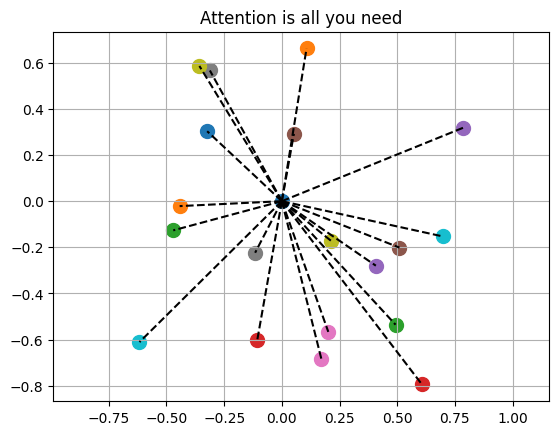

In [77]:
import matplotlib.pyplot as plt

for node, (x, y) in positions.items():
    plt.scatter(x, y, s=100)
    #plt.text(x + 0.1, y + 0.1, node)

for start, end in edges:
    if start in positions.keys() and end in positions.keys():
        x_values = [positions[start][0], positions[end][0]]
        y_values = [positions[start][1], positions[end][1]]
        plt.plot(x_values, y_values, 'k--', )
        plt.title(graph.search_query)

plt.axis('equal')
plt.grid(True)
plt.show()

In [80]:
for node, rel in zip(graph.nodes, relevances):
    theta = random.uniform(0, 2 * math.pi)  # random angle
    x = rel * math.cos(theta)
    y = rel * math.sin(theta)
    node.position = (x, y)

In [81]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objects as go

# Dummy data (replace with actual Node instances)
from typing import List, Tuple, Any
from dataclasses import dataclass


# Create ID → Node map
id_node_map = {node.id: node for node in nodes}


edges = [(primary_node.id, k) for k in primary_node.cites_by_id if k in [a.id for a in graph.nodes]]

# Dash app
app = dash.Dash(__name__)

def build_figure(nodes: List[Node], edges: List[Tuple[str, str]]):
    edge_x, edge_y = [], []
    for source_id, target_id in edges:
        x0, y0 = id_node_map[source_id].position
        x1, y1 = id_node_map[target_id].position
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x, node_y, node_text, node_ids = [], [], [], []

    for node in nodes:
        x, y = node.position
        node_x.append(x)
        node_y.append(y)
        node_text.append(node.title)
        node_ids.append(node.id)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=[n.title for n in nodes],
        textposition="bottom center",
        marker=dict(size=20, color='skyblue', line_width=2),
        hoverinfo='text',
        customdata=node_ids  # For click callbacks
    )

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='Interactive Research Graph',
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)
                    ))

    return fig

app.layout = html.Div([
    dcc.Graph(id='graph', figure=build_figure(nodes, edges)),
    html.Div(id='node-details', style={'whiteSpace': 'pre-line', 'padding': '20px', 'fontFamily': 'monospace'})
])

@app.callback(
    Output('node-details', 'children'),
    Input('graph', 'clickData')
)
def display_node_details(clickData):
    if clickData and "points" in clickData:
        point = clickData["points"][0]
        node_id = point["customdata"]
        node = id_node_map[node_id]
        return f"""
📄 Title: {node.title}
🔗 DOI: {node.doi}
📅 Year: {node.publication_year}
📈 Citations: {node.total_citations}
🏷️ Keywords: {node.keywords}
        """
    return "Click a node to view details."

if __name__ == '__main__':
    app.run(debug=True)


For one paper

- Get references
- populate nodes
- Linking based on ids
- Randomly distribute across space keep the main one in the centre
- Size of the nodes based on total citations

(later)
- Create graph - use very simple topic based space configuration - LLM call
